In [3]:
!pip install tensorflow==2.16.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 750.6 kB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - loss: 0.1418 - val_loss: 0.0475
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0188 - val_loss: 0.0226
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0120 - val_loss: 0.0186
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0103 - val_loss: 0.0189
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0105 - val_loss: 0.0192
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0111 - val_loss: 0.0209
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0097 - val_loss: 0.0226
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0111 - val_loss: 0.0249
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0111 - val_loss: 0.0285
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0103 - val_loss: 0.0328
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0129 - val_loss: 0.0271
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/s

Model saved successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
Mean Squared Error (MSE): 4.793953464553124
Mean Absolute Error (MAE): 1.66861995897795
Root Mean Squared Error (RMSE): 2.1895098685671925

Actual vs Predicted vs Difference:
    Actual  Predicted  Difference
0     22.2  21.311110    0.888890
1     22.0  22.545580    0.545580
2     21.7  22.026737    0.326737
3     22.4  21.808201    0.591799
4     23.4  22.318560    1.081440
..     ...        ...         ...
71    31.5  31.805210    0.305210
72    31.5  31.102421    0.397579
73    33.1  31.330059    1.769941
74    34.1  32.705002    1.394998
75    32.3  32.835464    0.535464

[76 rows x 3 columns]


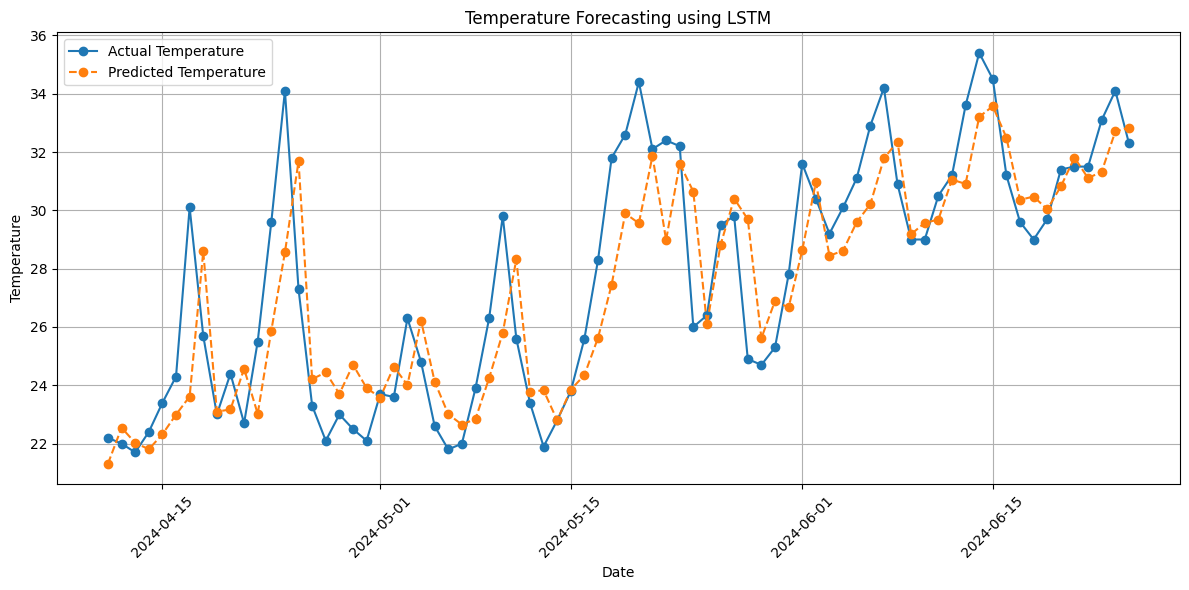

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
data = pd.read_csv('Cairo,Egypt 2023-01-01 to 2024-06-25.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Extract only 'temp' column for forecasting
data = data[['temp']]

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Function to create dataset for LSTM
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            res.append(df[i + j])
        xRes.append(res)
        yRes.append(df[i + window])
    return np.array(xRes), np.array(yRes)

# Splitting dataset into train and test with window size 40
SPLIT = 0.85
window_size = 40  # Adjusted window size
X, y = singleStepSampler(data_scaled, window_size)
X_train = X[:int(SPLIT * len(X))]
y_train = y[:int(SPLIT * len(y))]
X_test = X[int(SPLIT * len(X)):]
y_test = y[int(SPLIT * len(y)):]

# LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(window_size, 1)))  # Adjusted input shape
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save the model
model.save('lstm_temperature_forecasting_model.h5')
print("Model saved successfully.")

# Forecasting
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)  # Inverse transform to get original scale
y_test_orig = scaler.inverse_transform(y_test)  # Inverse transform to get original scale

# Calculate metrics
mse = mean_squared_error(y_test_orig, predicted_values)
mae = mean_absolute_error(y_test_orig, predicted_values)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Print actual vs predicted vs difference
print("\nActual vs Predicted vs Difference:")
results = pd.DataFrame({'Actual': y_test_orig.flatten(), 'Predicted': predicted_values.flatten()})
results['Difference'] = np.abs(results['Actual'] - results['Predicted'])
print(results)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_orig):], y_test_orig, label='Actual Temperature', marker='o')
plt.plot(data.index[-len(y_test_orig):], predicted_values, label='Predicted Temperature', linestyle='--', marker='o')
plt.title('Temperature Forecasting using LSTM')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load dataset
data = pd.read_csv('Cairo,Egypt 2023-01-01 to 2024-06-25.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Extract only 'temp' column for forecasting
data = data[['temp']]

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Load the trained LSTM model
model = load_model('lstm_temperature_forecasting_model.h5')

# Function to create dataset for LSTM forecasting
def singleStepSampler(df, window):
    xRes = []
    for i in range(len(df) - window, len(df)):
        xRes.append(df[i - window:i])
    return np.array(xRes)

# Determine the window size and exclude the last seven rows
window_size = 40

# Ensure we have enough rows to create a full window
if len(data_scaled) >= window_size + 7:  # Ensure enough data points
    last_window = data_scaled[-(window_size + 7):-7]  # Exclude last seven rows for forecasting
    actual_values = data_scaled[-7:]  # Actual last seven rows for comparison
else:
    print("Not enough data to create the window.")
    exit()

# Reshape for model input
last_window = np.expand_dims(last_window, axis=0)  # Add batch dimension

# Ensure shape matches (None, 40, 1)
assert last_window.shape == (1, window_size, 1), f"Expected shape (1, {window_size}, 1), got {last_window.shape}"

# Forecasting for the next 7 days
forecasted_temps = []
for _ in range(7):
    predicted_temp_scaled = model.predict(last_window)
    forecasted_temps.append(predicted_temp_scaled[0, 0])  # Append predicted temperature
    last_window = np.roll(last_window, -1, axis=1)  # Shift window one step forward along the time axis
    last_window[:, -1, 0] = predicted_temp_scaled  # Update last element with predicted value

# Inverse transform to get original scale
forecasted_temps = scaler.inverse_transform(np.array(forecasted_temps).reshape(-1, 1))
actual_temps = scaler.inverse_transform(actual_values)  # Inverse transform actual values

# Printing forecasted and actual temperatures
print("Forecasted Temperatures for the Next 7 Days:")
for i, temp in enumerate(forecasted_temps.flatten(), start=1):
    print(f"Day {i}: Forecasted Temp: {temp:.2f} °C, Actual Temp: {actual_temps[i-1][0]:.2f} °C")




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Forecasted Temperatures for the Next 7 Days:
Day 1: Forecasted Temp: 30.03 °C, Actual Temp: 29.70 °C
Day 2: Forecasted Temp: 31.13 °C, Actual Temp: 31.40 °C
Day 3: Forecasted Temp: 31.38 °C, Actual Temp: 31.50 °C
Day 4: Forecasted Temp: 31.24 °C, Actual Temp: 31.50 °C
Day 5: Forecasted Temp: 31.03 °C, Actual Temp: 33.10 °C
Day 6: Forecasted Temp: 30.89 °C, Actual Temp: 34.10 °C
Day 7: Forecasted Temp: 30.81 °C, Actual Temp: 32.30 °C
